
## Print figures of Himawari SST data in regions (distributed)


In [1]:
import os, sys, shutil
from glob import glob
#
%matplotlib inline
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask import compute, delayed
# 
from datetime import datetime
import pandas as pd
#
from hw.utils import *

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


satpy not available


In [2]:
# launch cluster and workers

# folder where data is spilled when RAM is filled up
#local_dir = os.getenv('HOME')+'/dask_scratch/'
#local_dir = os.getenv('SCRATCH')+'/dask_scratch/'
#local_dir = os.getenv('DATAWORK')+'/dask_scratch/'
local_dir = os.getenv('TMPDIR')
#
cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                     threads=14, processes=2, memory='50GB', resource_spec='select=1:ncpus=28:mem=100g', 
                     death_timeout=100)


In [3]:
cluster.start_workers(4)

[2, 3, 4, 5]

In [5]:
cluster.scheduler

<Scheduler: "tcp://10.148.1.112:48239" processes: 8 cores: 112>

In [6]:
### get dask handles and check dask server status
client = Client(cluster)

In [7]:
client

Client Scheduler: tcp://10.148.1.112:48239 Dashboard: http://10.148.1.112:51877/status,Cluster Workers: 8 Cores: 112 Memory: 400.00 GB


In [8]:
# data path
region = 'NWA'; vmin = 20.; vmax = 35.
region = 'NWAM'; vmin = 26.; vmax = 32.
region = 'WA'; t1, t2, suff, vmin, vmax, slat, slon = datetime(2016,9,3), datetime(2016,9,16), '_t1z', 23., 30., slice(-12,-24), slice(108,126)

#
dpath = '/home/datawork-lops-osi/data/hw/sst/'+region+'/';
#figdir = '/home1/datawork/aponte/hw/figs/'

filenames = sorted(glob(dpath+region+'_*.nc'))
print('Number of files available: %d' %len(filenames))
Nfiles = len(filenames)
# tmp, subset number of files (skip last file that may be incomplete)
#filenames = filenames[:-1]

# consider a time subset
times = [datetime.strptime(f,dpath+region+'_%Y%m%d%H%M.nc') for f in filenames]
if 't1' in locals() and 't2' in locals():
    filenames  = [f for f,t in zip(filenames,times) if (t>t1) and (t<t2)]
print('Number of files processed: %d' %len(filenames))

Number of files available: 54904
Number of files processed: 1842


In [9]:
# open files
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')

# spatial zoom
if 'slat' in locals():
    ds = ds.sel(lat=slat)

# sst in degC
ds['sea_surface_temperature'] += -273.15
ds['sea_surface_temperature'] = ds['sea_surface_temperature'].where(ds['sea_surface_temperature']>0)

print('SST dataset size: %.1f GB' %(ds['sea_surface_temperature'].nbytes/1e9))

CPU times: user 32 s, sys: 2.75 s, total: 34.7 s
Wall time: 1min 16s
SST dataset size: 4.4 GB


In [10]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 601, lon: 1001, time: 1842)
Coordinates:
  * lat                      (lat) float32 -12.0 -12.019997 -12.040001 ...
  * lon                      (lon) float32 105.0 105.02 105.04 105.06 105.08 ...
  * time                     (time) datetime64[ns] 2016-09-03T00:10:17 ...
Data variables:
    sea_surface_temperature  (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    wind_speed               (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
    solar_zenith_angle       (time, lat, lon) float32 dask.array<shape=(1842, 601, 1001), chunksize=(1, 601, 1001)>
Attributes:
    Conventions:                CF-1.4,Unidata Observation Dataset v1.0
    title:                      Sea Surface Temperature from AHI onboard Hima...
    summary:                    TBD
    references:                 TBD
    institution:                Japan Aerospace Exploration Agency(JAXA)
  

---

# make movie

This is the best option to my opinion

In [14]:

figdir = '/home1/datawork/aponte/hw/figs/'
shutil.rmtree(figdir); os.mkdir(figdir)

def process(lds, i, overwrite=True):
    sst = lds['sea_surface_temperature']
    #
    time = pd.to_datetime(str(sst['time'].values))
    figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'
    #
    if not os.path.isfile(figname) or overwrite:
        #
        title = time.strftime('%Y%m%d_%H%M')
        plot_sst(sst, colorbar=False, title=title, savefig=figname, vmin=vmin, vmax=vmax, 
                 offline=True, coast_resolution='50m', figsize=(15,10))
        #
        m = float(sst.mean().values)
    else:
        m = -1.
    return m

I = range(len(ds['time']))
#I = range(100)
values = [delayed(process)(ds.isel(time=i), i) for i in I]


In [15]:
%time results = compute(*values, get=client.get)

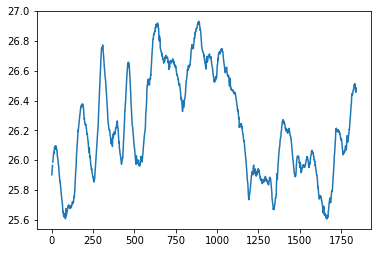

In [16]:
plt.plot(results)

---

# alternative movie making with apply_ufunc

This option is less elegant

In [24]:

# with apply_ufunc
def process(T, lon, lat, time):
    #
    #plot_sst(sst, colorbar=False, title=title, savefig=figname, 
    #         vmin=vmin, vmax=vmax, offline=True, coast_resolution='50m', figsize=(15,10))
    #
    plt.switch_backend('agg')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(T.squeeze())
    #figname = figdir+'hw_sst_'+region+'_'+time.strftime('%Y%m%d_%H%M')+suff+'.png'    
    figname = figdir+'hw_sst_'+region+'_'+str(time)+'.png'    
    fig.savefig(figname, dpi=150)
    plt.close(fig)
    #
    m = np.nanmean(np.nanmean(T,axis=1),axis=1)
    return m
    
M = xr.apply_ufunc(process, ds['sea_surface_temperature'].isel(time=slice(0,10)), 
                   ds['lon'], ds['lat'], ds['time'].isel(time=slice(0,10)),
                   input_core_dims=[['lon','lat'],['lon'],['lat'],[]], 
                   dask='parallelized', output_dtypes=[float])

print(M)

1842

In [ ]:
M.compute()

---

# info, shutdown

In [17]:
client

Client Scheduler: tcp://10.148.1.112:48239 Dashboard: http://10.148.1.112:51877/status,Cluster Workers: 8 Cores: 112 Memory: 400.00 GB


In [ ]:
client.restart()

In [18]:
client.close()
cluster.stop_workers(cluster.jobs)